# Hierarchical clustering demo

## 1. Algorithm implementation
It should be a tree, so we create a Node class first.

In [1]:
class BiClusterNode:
    def __init__(self,vec,left=None,right=None,distance=0.0,id=None):
        self.left=left
        self.right=right
        self.vec=vec
        self.id=id
        self.distance=distance

We still need all different distance metrics

In [2]:
from math import sqrt

def manhattan(v1,v2):
    res=0
    dimensions=min(len(v1),len(v2))

    for i in range(dimensions):
        res+=abs(v1[i]-v2[i])

    return res


def euclidean(v1,v2):
    res=0
    dimensions=min(len(v1),len(v2))
    for i in range(dimensions):
        res+=pow(abs(v1[i]-v2[i]),2)

    return sqrt(float(res))


def cosine(v1,v2):
    dotproduct=0
    dimensions=min(len(v1),len(v2))

    for i in range(dimensions):
        dotproduct+=v1[i]*v2[i]

    v1len=0
    v2len=0
    for i in range (dimensions):
        v1len+=v1[i]*v1[i]
        v2len+=v2[i]*v2[i]

    v1len=sqrt(v1len)
    v2len=sqrt(v2len)
    
    # we need distance here - 
    # we convert cosine similarity into distance
    return 1.0-(float(dotproduct)/(v1len*v2len))
  

def pearson(v1,v2):
    # Simple sums
    sum1=sum(v1)
    sum2=sum(v2)
  
    # Sums of the squares
    sum1Sq=sum([pow(v,2) for v in v1])
    sum2Sq=sum([pow(v,2) for v in v2])
  
    # Sum of the products
    pSum=sum([v1[i]*v2[i] for i in range(min(len(v1),len(v2)))])
  
    # Calculate r (Pearson score)
    numerator=pSum-(sum1*sum2/len(v1))
    denominator=sqrt((sum1Sq-pow(sum1,2)/len(v1))*(sum2Sq-pow(sum2,2)/len(v1)))
    if denominator==0: return 1.0
    
    # we need distance here - 
    # we convert pearson correlation into distance
    return 1.0-numerator/denominator


def tanimoto(v1,v2):
    c1,c2,shared=0,0,0

    for i in range(len(v1)):
        if v1[i]!=0 or v2[i]!= 0:
            if v1[i]!=0: c1+=1 # in v1
            if v2[i]!=0: c2+=1 # in v2
            if v1[i]!=0 and v2[i]!=0: shared+=1 # in both
    
    # we need distance here - 
    # we convert tanimoto overlap into distance
    return 1.0-(float(shared)/(c1+c2-shared))

Hierarchical clustering algorithm.

In [3]:
def hcluster(rows,distance=euclidean):
    distances={}
    currentclustid=-1

    # Clusters are initially just the rows
    clust=[BiClusterNode(rows[i],id=i) for i in range(len(rows))]

    while len(clust)>1:
        lowestpair=(0,1)
        closest=distance(clust[0].vec,clust[1].vec)

        # loop through every pair looking for the smallest distance
        for i in range(len(clust)):
            for j in range(i+1,len(clust)):
                # distances is the cache of distance calculations
                if (clust[i].id,clust[j].id) not in distances:
                    distances[(clust[i].id,clust[j].id)]=distance(clust[i].vec,clust[j].vec)

                d=distances[(clust[i].id,clust[j].id)]

                if d<closest:
                    closest=d
                    lowestpair=(i,j)

        # calculate the average of the two clusters
        mergevec=[
            (clust[lowestpair[0]].vec[i]+clust[lowestpair[1]].vec[i])/2.0
                    for i in range(len(clust[0].vec))]

        # create the new cluster
        newcluster=BiClusterNode(mergevec,left=clust[lowestpair[0]],
                             right=clust[lowestpair[1]],
                             distance=closest,id=currentclustid)

        # cluster ids that weren't in the original set are negative
        currentclustid-=1
        del clust[lowestpair[1]]
        del clust[lowestpair[0]]
        clust.append(newcluster)

    return clust[0]

Function for printing resulting dendrogram.

In [4]:
def printhclust(clust,labels=None,n=0):
    # indent to make a hierarchy layout
    for i in range(n):
        print (' ', end="")
    if clust.id<0:
    # negative id means that this is branch
        print ('-')
    else:
    # positive id means that this is an endpoint
        if labels==None: print (clust.id)
        else: print (labels[clust.id])

    # now print the right and left branches
    if clust.left!=None: printhclust(clust.left,labels=labels,n=n+1)
    if clust.right!=None: printhclust(clust.right,labels=labels,n=n+1)

And to draw the dendrogram.

In [5]:
# draw hierarchical clusters
from PIL import Image,ImageDraw

def getheight(clust):
    # Is this an endpoint? Then the height is just 1
    if clust.left==None and clust.right==None: return 1

    # Otherwise the height is the same of the heights of
    # each branch
    return getheight(clust.left)+getheight(clust.right)


def getdepth(clust):
    # The distance of an endpoint is 0.0
    if clust.left==None and clust.right==None: return 0

    # The distance of a branch is the greater of its two sides
    # plus its own distance
    return max(getdepth(clust.left),getdepth(clust.right))+clust.distance


def drawdendrogram(clust,labels,jpeg='clusters.jpg'):
    # height and width
    h=getheight(clust)*20
    w=1200
    depth=getdepth(clust)

    # width is fixed, so scale distances accordingly
    scaling=float(w-150)/depth

    # Create a new image with a white background
    img=Image.new('RGB',(w,h),(255,255,255))
    draw=ImageDraw.Draw(img)

    draw.line((0,h/2,10,h/2),fill=(255,0,0))

    # Draw the first node
    drawnode(draw,clust,10,(h/2),scaling,labels)
    img.save(jpeg,'JPEG')


def drawnode(draw,clust,x,y,scaling,labels):
    if clust.id<0:
        h1=getheight(clust.left)*20
        h2=getheight(clust.right)*20
        top=y-(h1+h2)/2
        bottom=y+(h1+h2)/2
        # Line length
        ll=clust.distance*scaling
        # Vertical line from this cluster to children
        draw.line((x,top+h1/2,x,bottom-h2/2),fill=(255,0,0))

        # Horizontal line to left item
        draw.line((x,top+h1/2,x+ll,top+h1/2),fill=(255,0,0))

        # Horizontal line to right item
        draw.line((x,bottom-h2/2,x+ll,bottom-h2/2),fill=(255,0,0))

        # Call the function to draw the left and right nodes
        drawnode(draw,clust.left,x+ll,top+h1/2,scaling,labels)
        drawnode(draw,clust.right,x+ll,bottom-h2/2,scaling,labels)
    else:
        # If this is an endpoint, draw the item label
        draw.text((x+5,y-7),labels[clust.id],(0,0,0))

## 2. Same toy dataset: clustering papers by title
The input is a vector of words for each document, created from the paper titles in file [titles.txt](titles.txt), and stored in file  [titles_vectors.txt](titles_vectors.txt).

In [6]:
# The same function to read vectors file
def read_vector_file(file_name):
    f = open(file_name)
    lines=[line for line in f]
  
    # First line is the column headers
    colnames=lines[0].strip().split('\t')[:]
    print(colnames)
    rownames=[]
    data=[]
    for line in lines[1:]:
        p=line.strip().split('\t')
        # First column in each row is the rowname
        if len(p)>1:
            rownames.append(p[0])
            # The data for this row is the remainder of the row
            data.append([float(x) for x in p[1:]])
    return rownames,colnames,data

The same function to rotate the matrix.

In [7]:
def rotatematrix(data):
    newdata=[]
    for i in range(len(data[0])):
        newrow=[data[j][i] for j in range(len(data))]
        newdata.append(newrow)
    return newdata

Build hierarchy of clusters and print it.

In [8]:
file_name = "titles_vectors.txt"
docs,words,data=read_vector_file(file_name)

clust=hcluster(data,distance=euclidean)
print ('clusters of documents')
printhclust(clust,labels=docs)

['interface', 'trees', 'time', 'user', 'survey', 'system', 'graph', 'minors', 'eps', 'human', 'computer', 'response']
clusters of documents
-
 -
  d3
  d4
 -
  -
   d2
   d5
  -
   d1
   -
    d9
    -
     d8
     -
      d6
      d7


In [9]:
drawdendrogram(clust,docs,jpeg='docsclust_image.jpg')

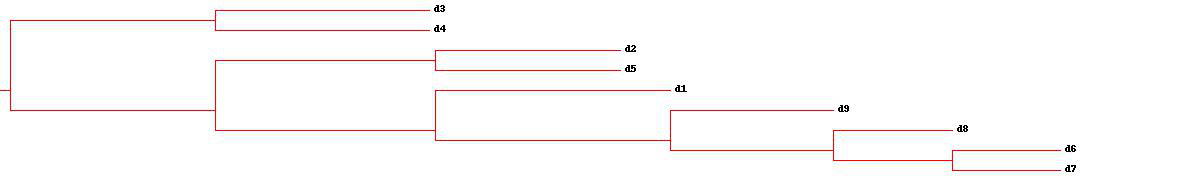

In [10]:
from PIL import Image               # to load images
from IPython.display import display # to display images

pil_im = Image.open('docsclust_image.jpg')
display(pil_im)

And these are our original documents:
- `['d1', {'human': 1, 'interface': 1, 'computer': 1}]`
- `['d2', {'survey': 1, 'user': 1, 'computer': 1, 'system': 1, 'response': 1, 'time': 1}]`
- `['d3', {'eps': 1, 'user': 1, 'interface': 1, 'system': 1}]`
- `['d4', {'system': 2, 'human': 1, 'eps': 1}]`
- `['d5', {'user': 1, 'response': 1, 'time': 1}]`
- `['d6', {'trees': 1}]`
- `['d7', {'graph': 1, 'trees': 1}]`
- `['d8', {'graph': 1, 'minors': 1, 'trees': 1}]`
- `['d9', {'graph': 1, 'minors': 1, 'survey': 1}]`

## 3. Clustering words by their co-occurrence in documents
If we want to cluster words by their occurrences in the documents, all we need to do is to transpose the matrix.

In [11]:
rdata=rotatematrix(data)
clust=hcluster(rdata,distance=euclidean)
print ('hierarchical clusters of words')
printhclust(clust,labels=words)
drawdendrogram(clust,words,jpeg='wordsclust_image.jpg')

hierarchical clusters of words
-
 system
 -
  -
   -
    user
    -
     time
     response
   -
    survey
    -
     computer
     -
      human
      -
       interface
       eps
  -
   trees
   -
    graph
    minors


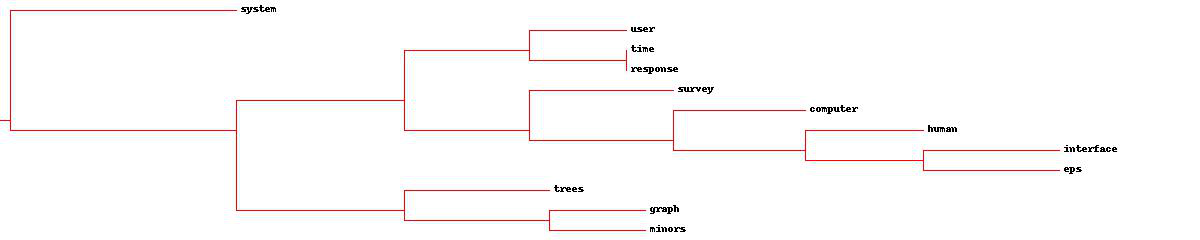

In [12]:
pil_im = Image.open('wordsclust_image.jpg')
display(pil_im)

Copyright &copy; 2020 Marina Barsky. All rights reserved.